# Predicting dominant landcover class using satellite imagery  

※ Last modified: 2022/01/10 by Jeongkyung Won (jongrudwon@sogang.ac.kr)

1. Assign dominant landcover class to each wayback grid  
  1.1. Loading all landcover classficiation raster files  
  1.2. Raster Merge (=Raster Mosaic)  
  1.3. Zonal Statistics to obtain dominant landcover class for each grid  
  1.4. Constructing a final df for machine learning

2. Prediction

## *Imports

In [ ]:
# Common imports
import numpy as np
import os
import pandas as pd
import cv2
import time

import shutil
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.data import AUTOTUNE

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
"""
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
"""

# random seed
my_seed = 42

# to make this notebook's output stable across runs
np.random.seed(my_seed)

## *TPU Activation

In [ ]:
# tpu initilization

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.122.159.18:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.159.18:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
# distribution strategies

strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## *Configuration

In [ ]:
EPOCHS = 25
IMAGE_SIZE = [200, 200]
img_size = (200, 200)
#my_seed=42
my_seed=1

## *Mixed precision

On TPU, bfloat16/float32 mixed precision is automatically used in TPU computations.<br>
Enabling it in Keras also stores relevant variables in bfloat16 format (memory optimization).<br>
On GPU, specifically V100, mixed precision must be enabled for hardware TensorCores to be used.<br>
XLA compilation must be enabled for this to work. (On TPU, XLA compilation is the default)

In [ ]:
MIXED_PRECISION = False

if MIXED_PRECISION:
    if tpu: 
        policy = tf.keras.mixed_precision.Policy('mixed_bfloat16')
    else: #
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.config.optimizer.set_jit(True) # XLA compilation
    tf.keras.mixed_precision.set_global_policy(policy)
    print('Mixed precision enabled')


## *Learning Rate

In [ ]:
# batch and learning rate settings
if strategy.num_replicas_in_sync == 8: # TPU or 8xGPU
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00005 * strategy.num_replicas_in_sync
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8
elif strategy.num_replicas_in_sync == 1: # single GPU
    BATCH_SIZE = 16
    VALIDATION_BATCH_SIZE = 16
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.0002
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8
else: # TPU pod
    BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00002 * strategy.num_replicas_in_sync
    rampup_epochs = 7
    sustain_epochs = 0
    exp_decay = .8

1e-05 1.5620492334958385e-05


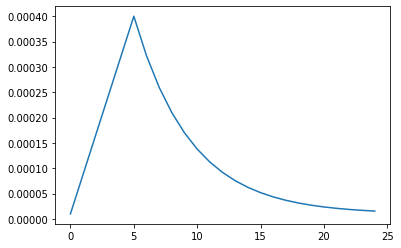

In [ ]:
def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

## *Display Utilities

In [ ]:
# display utilities

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.unbatch().batch(N)
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;  
  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  label = np.argmax(label, axis=-1)  # one-hot to class number
  correct_label = np.argmax(correct_label, axis=-1) # one-hot to class number
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[np.argmax(labels[i], axis=-1)]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  #plt.tight_layout() # bug in tight layout in this version of matplotlib
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(predictions[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  #plt.tight_layout() # bug in tight layout in this version of matplotlib
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    #plt.tight_layout() # bug in tight layout in this version of matplotlib
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  #ax.set_ylim(0.28,1.05)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

# 1. Assign dominant landcover class to each wayback grid

---



In [ ]:
import os
print(os.getcwd())

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/production

/content/drive/MyDrive/production


## 1.1. Loading all landcover classficiation raster files

In [ ]:
# landcover 폴더 안의 subfolder안의 모든 파일을 아래의 폴더에 모으기
def read_all_file(path):
   output = os.listdir(path) 
   file_list = [] 
   
   for i in output:
     if os.path.isdir(path+"/"+i):
       file_list.extend(read_all_file(path+"/"+i)) 
     elif os.path.isfile(path+"/"+i): 
       file_list.append(path+"/"+i) 
       
   return file_list 
   
def copy_all_file(file_list, new_path): 
   for src_path in file_list: 
       file = src_path.split("/")[-1] 
       shutil.copyfile(src_path, new_path+"/"+file) 
       print("파일 {} 작업 완료".format(file)) # 작업한 파일명 출력 
       
start_time = time.time() # 작업 시작 시간 

src_path = "./landcover" # 기존 폴더 경로 
new_path = "./landcover_merge" # 옮길 폴더 경로 

file_list = read_all_file(src_path) 
copy_all_file(file_list, new_path) 

print("=" * 40) 
print("러닝 타임 : {}".format(time.time() - start_time)) # 총 소요시간 계산


In [ ]:
# landcover_merge 폴더에서 모든 tif파일만
files=os.listdir('./landcover_merge')
working_files = [f for f in files if re.search('[\.]'+'tif'+'$', f)]
print(working_files)

['2010y_34606.tif', '2010y_36602.tif', '2010y_36706.tif', '2010y_37702.tif', '2010y_36712.tif', '2010y_34615.tif', '2010y_36605.tif', '2010y_35610.tif', '2010y_37716.tif', '2010y_35815.tif', '2010y_35702.tif', '2010y_37713.tif', '2010y_34610.tif', '2010y_37802.tif', '2010y_36615.tif', '2010y_37711.tif', '2010y_36810.tif', '2010y_34806.tif', '2010y_35715.tif', '2010y_35705.tif', '2010y_34609.tif', '2010y_35708.tif', '2010y_35608.tif', '2010y_34803.tif', '2010y_36704.tif', '2010y_35714.tif', '2010y_35808.tif', '2010y_36610.tif', '2010y_34708.tif', '2010y_34508.tif', '2010y_35710.tif', '2010y_36806.tif', '2010y_37613.tif', '2010y_36803.tif', '2010y_36708.tif', '2010y_37703.tif', '2010y_36811.tif', '2010y_35607.tif', '2010y_37807.tif', '2010y_36804.tif', '2010y_35701.tif', '2010y_35913.tif', '2010y_34713.tif', '2010y_37805.tif', '2010y_34504.tif', '2010y_35614.tif', '2010y_36713.tif', '2010y_34601.tif', '2010y_37714.tif', '2010y_34513.tif', '2010y_36701.tif', '2010y_37813.tif', '2010y_3451

In [ ]:
# landcover 폴더 안의 subfolder안의 모든 파일을 아래의 폴더에 옮겨담기
!mkdir landcover_merge

mkdir: cannot create directory ‘landcover_merge’: File exists


In [ ]:
import re
import shutil
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import box
from pathlib import Path
from pandas import DataFrame as df

In [ ]:
# landcover 폴더에서 unzip
!unzip -qq "./landcover/대분류토지피복지도_2010년대말_전국.zip" -d "./landcover"

replace ./landcover/ыМАы╢ДыеШэЖаьзАэФ╝ы│╡ьзАыПД_2010ыЕДыМАызР_ьаДъ╡н/ReadMe.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## 1.2. Raster Merge (=Raster Mosaic)

In [ ]:
pip install rioxarray

In [ ]:
pip install rasterio

In [ ]:
pip install rasterstats

In [ ]:
import rasterstats
import rioxarray as rxr
import rasterio as rio
from rasterio.crs import CRS
from rasterio.plot import show
from rasterio.merge import merge

In [ ]:
# tiff 파일 merge하기 

Path('output').mkdir(parents=True, exist_ok=True)
output_path='output/mosaic_output.tif'

raster_to_mosaic= []

for f in working_files:
  raster=rio.open('./landcover_merge/'+f)
  raster_to_mosaic.append(raster)

In [ ]:
mosaic, output=merge(raster_to_mosaic)

In [ ]:
output_meta=raster.meta.copy()
output_meta.update(
    {"driver": "GTiff",
     "height":mosaic.shape[1],
     "width":mosaic.shape[2],
     "transform":output,        
    }
)

In [ ]:
with rio.open(output_path,'w',**output_meta) as m:
  m.write(mosaic)
  m.crs=CRS.from_epsg(5186)

## 1.3. Zonal Statistics

In [ ]:
pip install geopandas

In [ ]:
import geopandas as gpd


In [ ]:
!unzip -qq "./cookie_mold/wayback_grid_kr_zl15.zip" -d "./cookie_mold"

In [ ]:
# zonal statistics로 wayback grid별로 majority class 구하기
dir_shp="./cookie_mold/wayback_grid_kr_zl15.shp"
dir_raster="./output/mosaic_output.tif"
dir_out="./output"

mask=gpd.read_file(dir_shp, encoding='euc-kr')
mask.head(3)

,y_x,begin,end,geometry
0,12996_27890,1,4,"POLYGON ((126.40869 34.84988, 126.40869 34.849..."
1,12997_27889,1,4,"POLYGON ((126.39771 34.84086, 126.40869 34.840..."
2,12997_27890,1,4,"POLYGON ((126.40869 34.84086, 126.41968 34.840..."


In [ ]:
raster=rio.open(dir_raster)
raster_array=raster.read(1)
affine=raster.transform

start_time = time.time() # 작업 시작 시간 

majority=rasterstats.zonal_stats(mask,raster_array,
                                 affine=affine, stats=['majority'],geojson_out = True)

majority_lc= []
i=0

while i< len(majority):
  majority_lc.append(majority[i]['properties'])
  i+=1

df=pd.DataFrame(majority_lc)
df.to_csv(dir_out+'wayback_grid_majority_lc.csv')

print("러닝 타임 : {}".format(time.time() - start_time)) # 총 소요시간 계산

## 1.4. Creating a final df for machine learning  
*  Matching filepaths of each satellite images with the corresponding landcover class label


In [ ]:
!ls satellite_image_download/kr_zl15

1    115  131  148  164  180  197  212	229  245  36  52  69  85
10   116  132  149  165  181  198  213	23   246  37  53  7   86
100  117  133  15   166  182  199  214	230  247  38  54  70  87
101  118  134  150  167  183  2    215	231  248  39  55  71  88
102  119  135  151  168  184  20   216	232  249  4   56  72  89
103  12   136  152  169  185  200  217	233  25   40  57  73  9
104  120  137  153  17	 186  201  218	234  250  41  58  74  90
105  121  138  154  170  187  202  219	235  26   42  59  75  91
106  122  139  155  171  188  203  22	236  27   43  6   76  92
107  123  14   156  172  189  204  220	237  28   44  60  77  93
108  124  140  157  173  19   205  221	238  29   45  61  78  94
109  125  141  158  174  190  206  222	239  3	  46  62  79  95
11   126  142  159  175  191  207  223	24   30   47  63  8   96
110  127  143  16   176  192  208  224	240  31   48  64  80  97
111  128  144  160  177  193  209  225	241  32   49  65  81  98
112  129  145  161  178  194  21   226	242  

In [ ]:
image_dir=Path('satellite_image_download/kr_zl15')

In [ ]:
filepaths=pd.Series(list(image_dir.glob(r'**/*.png')),name='filepath').astype(str)

In [ ]:
len(filepaths)

108079

In [ ]:
filepaths

0         satellite_image_download/kr_zl15/80/12992_2789...
1         satellite_image_download/kr_zl15/80/12962_2788...
2         satellite_image_download/kr_zl15/80/12976_2789...
3         satellite_image_download/kr_zl15/80/12984_2788...
4         satellite_image_download/kr_zl15/80/12992_2789...
                                ...                        
108074    satellite_image_download/kr_zl15/70/13148_2788...
108075    satellite_image_download/kr_zl15/70/13142_2791...
108076    satellite_image_download/kr_zl15/70/13153_2788...
108077    satellite_image_download/kr_zl15/70/13159_2789...
108078    satellite_image_download/kr_zl15/70/13142_2791...
Name: filepath, Length: 108079, dtype: object

In [ ]:
os.path.split(filepaths.values[0])

('satellite_image_download/kr_zl15/80', '12992_27891.png')

In [ ]:
os.path.splitext(filepaths.values[0])

('satellite_image_download/kr_zl15/80/12992_27891', '.png')

In [ ]:
os.path.splitext(os.path.split(filepaths.values[0])[1])

('12992_27891', '.png')

In [ ]:
os.path.splitext(os.path.split(filepaths.values[0])[1])[0]

'12992_27891'

In [ ]:
filepaths.apply(lambda x: os.path.splitext(os.path.split(x)[1])[0]).astype(str)

0         12992_27891
1         12962_27883
2         12976_27891
3         12984_27888
4         12992_27892
             ...     
108074    13148_27881
108075    13142_27913
108076    13153_27881
108077    13159_27893
108078    13142_27914
Name: filepath, Length: 108079, dtype: object

In [ ]:
gid=pd.Series(filepaths.apply(lambda x: os.path.splitext(os.path.split(x)[1])[0]), name='gid').astype(str)

In [ ]:
gid

0         12992_27891
1         12962_27883
2         12976_27891
3         12984_27888
4         12992_27892
             ...     
108074    13148_27881
108075    13142_27913
108076    13153_27881
108077    13159_27893
108078    13142_27914
Name: gid, Length: 108079, dtype: object

In [ ]:
#combine these two together

images=pd.concat([filepaths, gid],axis=1).sample(frac=1.0,random_state=1).reset_index(drop=True)

In [ ]:
images

,filepath,gid
0,satellite_image_download/kr_zl15/179/12742_281...,12742_28136
1,satellite_image_download/kr_zl15/188/12941_279...,12941_27977
2,satellite_image_download/kr_zl15/214/12896_279...,12896_27944
3,satellite_image_download/kr_zl15/80/12967_2788...,12967_27881
4,satellite_image_download/kr_zl15/249/12833_281...,12833_28129
...,...,...
108074,satellite_image_download/kr_zl15/133/12876_280...,12876_28003
108075,satellite_image_download/kr_zl15/249/12819_281...,12819_28138
108076,satellite_image_download/kr_zl15/198/12933_280...,12933_28024
108077,satellite_image_download/kr_zl15/117/12691_279...,12691_27956


In [ ]:
# take all of images for prediction

images_df=images

#take only 20% of images

#images_df=images.sampe(frac=0.2, random_state=1).reset_index(drop=True)

In [ ]:
cols=['gid','class']
target_df=pd.read_csv('wayback_grid_with_landcover_class_v3.csv', header=0, names=cols, usecols=[0,1])
target_df

,gid,class
0,12996_27890,2
1,12997_27889,1
2,12997_27890,3
3,12997_27891,2
4,12998_27888,1
...,...,...
94304,12925_27936,3
94305,12926_27923,3
94306,12926_27924,3
94307,12926_27925,3


In [ ]:
#merge class

images_df=images_df.merge(target_df,how='left', left_on='gid', right_on='gid').astype(str)
images_df

,filepath,gid,class
0,satellite_image_download/kr_zl15/179/12742_281...,12742_28136,3.0
1,satellite_image_download/kr_zl15/188/12941_279...,12941_27977,3.0
2,satellite_image_download/kr_zl15/214/12896_279...,12896_27944,3.0
3,satellite_image_download/kr_zl15/80/12967_2788...,12967_27881,2.0
4,satellite_image_download/kr_zl15/249/12833_281...,12833_28129,3.0
...,...,...,...
108074,satellite_image_download/kr_zl15/133/12876_280...,12876_28003,3.0
108075,satellite_image_download/kr_zl15/249/12819_281...,12819_28138,3.0
108076,satellite_image_download/kr_zl15/198/12933_280...,12933_28024,3.0
108077,satellite_image_download/kr_zl15/117/12691_279...,12691_27956,1.0


In [ ]:
# drop if class labels are missing
images_df=images_df[images_df['class']!='nan']
images_df

,filepath,gid,class
0,satellite_image_download/kr_zl15/179/12742_281...,12742_28136,3.0
1,satellite_image_download/kr_zl15/188/12941_279...,12941_27977,3.0
2,satellite_image_download/kr_zl15/214/12896_279...,12896_27944,3.0
3,satellite_image_download/kr_zl15/80/12967_2788...,12967_27881,2.0
4,satellite_image_download/kr_zl15/249/12833_281...,12833_28129,3.0
...,...,...,...
108074,satellite_image_download/kr_zl15/133/12876_280...,12876_28003,3.0
108075,satellite_image_download/kr_zl15/249/12819_281...,12819_28138,3.0
108076,satellite_image_download/kr_zl15/198/12933_280...,12933_28024,3.0
108077,satellite_image_download/kr_zl15/117/12691_279...,12691_27956,1.0


In [ ]:
images_df=images_df.drop(columns=['gid'])
images_df

,filepath,class
0,satellite_image_download/kr_zl15/179/12742_281...,3.0
1,satellite_image_download/kr_zl15/188/12941_279...,3.0
2,satellite_image_download/kr_zl15/214/12896_279...,3.0
3,satellite_image_download/kr_zl15/80/12967_2788...,2.0
4,satellite_image_download/kr_zl15/249/12833_281...,3.0
...,...,...
108074,satellite_image_download/kr_zl15/133/12876_280...,3.0
108075,satellite_image_download/kr_zl15/249/12819_281...,3.0
108076,satellite_image_download/kr_zl15/198/12933_280...,3.0
108077,satellite_image_download/kr_zl15/117/12691_279...,1.0


In [ ]:
images_df.loc[images_df['class']=='4.0','class']='3.0' # integrating grass and forest into one. (flora)

In [ ]:
images_df["type"]=images_df["class"]

In [ ]:
images_df.loc[images_df.type=='1.0','type']='urban'
images_df.loc[images_df.type=='2.0','type']='agriculture'
images_df.loc[images_df.type=='3.0','type']='flora'
images_df.loc[images_df.type=='5.0','type']='wetland'
images_df.loc[images_df.type=='6.0','type']='barren'
images_df.loc[images_df.type=='7.0','type']='water'

In [ ]:
images_df["type"].value_counts()

flora          73961
agriculture    16425
urban           3965
water           2611
wetland          516
barren           301
Name: type, dtype: int64

In [ ]:
images_df

,filepath,class,type
0,satellite_image_download/kr_zl15/179/12742_281...,3.0,flora
1,satellite_image_download/kr_zl15/188/12941_279...,3.0,flora
2,satellite_image_download/kr_zl15/214/12896_279...,3.0,flora
3,satellite_image_download/kr_zl15/80/12967_2788...,2.0,agriculture
4,satellite_image_download/kr_zl15/249/12833_281...,3.0,flora
...,...,...,...
108074,satellite_image_download/kr_zl15/133/12876_280...,3.0,flora
108075,satellite_image_download/kr_zl15/249/12819_281...,3.0,flora
108076,satellite_image_download/kr_zl15/198/12933_280...,3.0,flora
108077,satellite_image_download/kr_zl15/117/12691_279...,1.0,urban


In [ ]:
images_df.to_csv('./filepath_with_class_v6.csv',index=False)

# 2. Prediction  
2.1. Split train & test set  
2.2. Load Images  
2.3. Data Augmentation  
2.4. Build Model  
2.5. Train Model  
2.6. Check Plots  
2.7. Check Wrongly Predicted Images  
2.8. Confusion Matrix

## 2.1. Split train& test set

In [ ]:
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [ ]:
df=pd.read_csv("./filepath_with_class_v6.csv")
df
# check if missing variable
# images_df['class'].isnull().sum()

,filepath,class,type
0,satellite_image_download/kr_zl15/179/12742_281...,3.0,flora
1,satellite_image_download/kr_zl15/188/12941_279...,3.0,flora
2,satellite_image_download/kr_zl15/214/12896_279...,3.0,flora
3,satellite_image_download/kr_zl15/80/12967_2788...,2.0,agriculture
4,satellite_image_download/kr_zl15/249/12833_281...,3.0,flora
...,...,...,...
97774,satellite_image_download/kr_zl15/133/12876_280...,3.0,flora
97775,satellite_image_download/kr_zl15/249/12819_281...,3.0,flora
97776,satellite_image_download/kr_zl15/198/12933_280...,3.0,flora
97777,satellite_image_download/kr_zl15/117/12691_279...,1.0,urban


In [ ]:
df["type"].value_counts()

flora          73961
agriculture    16425
urban           3965
water           2611
wetland          516
barren           301
Name: type, dtype: int64

In [ ]:
# Save seperate dataframe by class to enable uniform sampling by class

df_barren=df.drop(df[df.type!='barren'].index)
df_barren=df_barren.sample(n=200)

df_wetland=df.drop(df[df.type!='wetland'].index)
df_wetland=df_wetland.sample(n=350)

df_water=df.drop(df[df.type!='water'].index)
df_water=df_water.sample(n=950)

df_urban=df.drop(df[df.type!='urban'].index)
df_urban=df_urban.sample(n=1450)

df_agriculture=df.drop(df[df.type!='agriculture'].index)
df_agriculture=df_agriculture.sample(n=1450)

df_flora=df.drop(df[df.type!='flora'].index)
df_flora=df_flora.sample(n=1600)


In [ ]:
df_urban=df_urban.append(df_agriculture)
df_urban=df_urban.append(df_flora)
df_urban=df_urban.append(df_wetland)
df_urban=df_urban.append(df_barren)
df_urban=df_urban.append(df_water)
train_df=df_urban
train_df

,filepath,class,type
31980,satellite_image_download/kr_zl15/37/12823_2798...,1.0,urban
43353,satellite_image_download/kr_zl15/104/12921_281...,1.0,urban
74039,satellite_image_download/kr_zl15/105/13005_278...,1.0,urban
93843,satellite_image_download/kr_zl15/154/12995_280...,1.0,urban
35221,satellite_image_download/kr_zl15/90/12756_2794...,1.0,urban
...,...,...,...
14726,satellite_image_download/kr_zl15/201/12987_279...,7.0,water
94012,satellite_image_download/kr_zl15/194/12974_278...,7.0,water
21031,satellite_image_download/kr_zl15/247/12794_278...,7.0,water
5435,satellite_image_download/kr_zl15/167/12667_281...,7.0,water


In [ ]:
test_df=pd.merge(train_df,df, indicator=True, how='outer')
test_df

,filepath,class,type,_merge
0,satellite_image_download/kr_zl15/37/12823_2798...,1.0,urban,both
1,satellite_image_download/kr_zl15/104/12921_281...,1.0,urban,both
2,satellite_image_download/kr_zl15/105/13005_278...,1.0,urban,both
3,satellite_image_download/kr_zl15/154/12995_280...,1.0,urban,both
4,satellite_image_download/kr_zl15/90/12756_2794...,1.0,urban,both
...,...,...,...,...
97774,satellite_image_download/kr_zl15/45/12879_2816...,3.0,flora,right_only
97775,satellite_image_download/kr_zl15/133/12876_280...,3.0,flora,right_only
97776,satellite_image_download/kr_zl15/249/12819_281...,3.0,flora,right_only
97777,satellite_image_download/kr_zl15/198/12933_280...,3.0,flora,right_only


In [ ]:
test_df=test_df.drop(test_df[test_df._merge=='both'].index)
test_df=test_df.drop(columns=['_merge'])
test_df

,filepath,class,type
6000,satellite_image_download/kr_zl15/179/12742_281...,3.0,flora
6001,satellite_image_download/kr_zl15/188/12941_279...,3.0,flora
6002,satellite_image_download/kr_zl15/214/12896_279...,3.0,flora
6003,satellite_image_download/kr_zl15/80/12967_2788...,2.0,agriculture
6004,satellite_image_download/kr_zl15/249/12833_281...,3.0,flora
...,...,...,...
97774,satellite_image_download/kr_zl15/45/12879_2816...,3.0,flora
97775,satellite_image_download/kr_zl15/133/12876_280...,3.0,flora
97776,satellite_image_download/kr_zl15/249/12819_281...,3.0,flora
97777,satellite_image_download/kr_zl15/198/12933_280...,3.0,flora


In [ ]:
test_df['type'].value_counts()

flora          72361
agriculture    14975
urban           2515
water           1661
wetland          166
barren           101
Name: type, dtype: int64

In [ ]:
test_df=test_df.reset_index()
test_df=test_df.drop(columns=['index'])
test_df

,filepath,class,type
0,satellite_image_download/kr_zl15/179/12742_281...,3.0,flora
1,satellite_image_download/kr_zl15/188/12941_279...,3.0,flora
2,satellite_image_download/kr_zl15/214/12896_279...,3.0,flora
3,satellite_image_download/kr_zl15/80/12967_2788...,2.0,agriculture
4,satellite_image_download/kr_zl15/249/12833_281...,3.0,flora
...,...,...,...
91774,satellite_image_download/kr_zl15/45/12879_2816...,3.0,flora
91775,satellite_image_download/kr_zl15/133/12876_280...,3.0,flora
91776,satellite_image_download/kr_zl15/249/12819_281...,3.0,flora
91777,satellite_image_download/kr_zl15/198/12933_280...,3.0,flora


In [ ]:
test_barren=test_df.drop(test_df[test_df.type!='barren'].index)
test_barren=test_barren.sample(n=70)

test_wetland=test_df.drop(test_df[test_df.type!='wetland'].index)
test_wetland=test_wetland.sample(n=120)

test_water=test_df.drop(test_df[test_df.type!='water'].index)
test_water=test_water.sample(n=300)

test_urban=test_df.drop(test_df[test_df.type!='urban'].index)
test_urban=test_urban.sample(n=480)

test_agriculture=test_df.drop(test_df[test_df.type!='agriculture'].index)
test_agriculture=test_agriculture.sample(n=480)

test_flora=test_df.drop(test_df[test_df.type!='flora'].index)
test_flora=test_flora.sample(n=550)

In [ ]:
test_urban=test_urban.append(test_agriculture)
test_urban=test_urban.append(test_flora)
test_urban=test_urban.append(test_wetland)
test_urban=test_urban.append(test_barren)
test_urban=test_urban.append(test_water)
test_df=test_urban
test_df

,filepath,class,type
72246,satellite_image_download/kr_zl15/90/12758_2794...,1.0,urban
91469,satellite_image_download/kr_zl15/201/12977_279...,1.0,urban
89769,satellite_image_download/kr_zl15/65/12738_2795...,1.0,urban
74647,satellite_image_download/kr_zl15/68/12730_2794...,1.0,urban
68313,satellite_image_download/kr_zl15/37/12821_2797...,1.0,urban
...,...,...,...
28535,satellite_image_download/kr_zl15/53/12909_2795...,7.0,water
7444,satellite_image_download/kr_zl15/193/12808_281...,7.0,water
17430,satellite_image_download/kr_zl15/164/12917_280...,7.0,water
45154,satellite_image_download/kr_zl15/84/12754_2791...,7.0,water


In [ ]:
# shuffle data frame
from sklearn.utils import shuffle
train_df_shuffled=shuffle(train_df, random_state=42)
test_df_shuffled = shuffle(test_df, random_state=42)

## 2.2. Load images into memory

In [ ]:
train_img_paths=train_df_shuffled['filepath'].to_numpy()
train_img_paths

array(['satellite_image_download/kr_zl15/42/12764_27965.png',
       'satellite_image_download/kr_zl15/173/12932_28135.png',
       'satellite_image_download/kr_zl15/19/12661_27975.png', ...,
       'satellite_image_download/kr_zl15/187/232/13015_27885.png',
       'satellite_image_download/kr_zl15/154/12994_28013.png',
       'satellite_image_download/kr_zl15/243/12705_27956.png'],
      dtype=object)

In [ ]:
# prepare for array version of file paths (inputs)
train_labels=train_df_shuffled['class'].to_numpy()
train_types=train_df_shuffled['type'].to_numpy()
train_labels[:30]

array([2., 3., 1., 2., 7., 1., 1., 1., 2., 1., 7., 2., 1., 1., 3., 2., 2.,
       7., 1., 1., 1., 7., 3., 2., 7., 3., 2., 7., 3., 3.])

In [ ]:
test_img_paths=test_df_shuffled['filepath'].to_numpy()
test_img_paths
print(len(test_img_paths))

2000


In [ ]:
# prepare for array version of file paths (inputs)
test_labels=test_df_shuffled['class'].to_numpy()
test_types=test_df_shuffled['type'].to_numpy()
test_labels[:30]

array([7., 1., 3., 2., 3., 3., 2., 7., 1., 3., 1., 3., 3., 2., 1., 1., 2.,
       1., 6., 7., 2., 6., 7., 3., 7., 1., 3., 3., 2., 1.])

In [ ]:
# encode label (to 0, 1, 2, ...)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
test_labels=le.fit_transform(test_labels)
#y_train_expanded_cat = le.transform(y_train_expanded)

In [ ]:
test_labels[:30]

array([5, 0, 2, 1, 2, 2, 1, 5, 0, 2, 0, 2, 2, 1, 0, 0, 1, 0, 4, 5, 1, 4,
       5, 2, 5, 0, 2, 2, 1, 0])

In [ ]:
# one hot encoding
from tensorflow.keras.utils import to_categorical
train_label=to_categorical(train_labels)
test_label=to_categorical(test_labels)
test_label[:30]

array([[0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=flo

In [ ]:
# prepare to load images into memory

img_size = (200, 200)
num_imgs = len(train_img_paths)+len(test_img_paths)

num_imgs

8000

In [ ]:
# number of samples for train, validation, test

# if too many images are put into numpy arrays, it will crash session 
# 'proto_buffer_writer.h:83] assertion failed: byte_count_ < total_size_'

"""
Protobuf has a hard limit of 2GB per call, and TensorFlow can split only 
tf.data.Dataset entities via multiple Protobuf messages. 
You should either make your dataset less than 2 GB or convert it to the 
TensorFlow Dataset format.
"""

num_train_samples = 6000 # 2000 images will be validation samples
num_test_samples = 2000

In [ ]:
# function: image to array

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

In [ ]:
# initiate an empty array (filled with np.zeros) for images

train_imgs = np.zeros((num_train_samples,) + img_size + (3,), dtype="uint8") ## float -> uint8 to reduce memory burden
test_imgs = np.zeros((num_test_samples,) + img_size + (3,), dtype="uint8") ## "

In [ ]:
from tqdm import tqdm

In [ ]:
# put images to array
from tensorflow.keras.utils import load_img, img_to_array

for i in tqdm(range(num_train_samples)):
  train_imgs[i] = path_to_input_image(train_img_paths[i])

100%|██████████| 6000/6000 [21:04<00:00,  4.75it/s]


In [ ]:
for i in tqdm(range(num_test_samples)):
  test_imgs[i]=path_to_input_image(test_img_paths[i])

100%|██████████| 2000/2000 [06:12<00:00,  5.36it/s]


In [ ]:
# train, val, test split 

train_input_imgs = train_imgs[0:4000]
train_targets = train_label[0:4000]

val_input_imgs = train_imgs[4000:num_train_samples]
val_targets = train_label[4000:num_train_samples]

test_input_imgs = test_imgs[:num_test_samples]
test_targets = test_label[:num_test_samples]

print(train_targets.shape, val_targets.shape, test_targets.shape)

(4000, 6) (2000, 6) (2000, 6)


## 2.3. Data to TF Dataset

In [ ]:
# set batch size

batch_size = 64
#batch_size = 128

my_batch_size = BATCH_SIZE
my_val_batch_size = VALIDATION_BATCH_SIZE

TRAIN_STEPS = len(train_targets) // BATCH_SIZE

validation_steps = len(val_targets) // my_val_batch_size

# train model faster with "steps_per_execution"
# anything between 2 and `steps_per_epoch` could help here.
my_steps_per_execution = TRAIN_STEPS // 2
my_steps_per_execution

15

In [ ]:
# normalize images

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

# Applying normalization before `ds.cache()` to re-use it.
# Note: Random transformations (e.g. images augmentations) should be applied
# after both `ds.cache()` (to avoid caching randomness) and `ds.batch()` (for
# vectorization [1]).


In [ ]:
# image augmentation

def augment_using_ops(images, labels):
	images = tf.image.random_flip_left_right(images)
	images = tf.image.random_flip_up_down(images)
	images = tf.image.rot90(images)
	return (images, labels)

In [ ]:
# prepare train data as tf.data.Dataset


# If you wish to randomize the iteration order, make sure to call shuffle after calling cache.

# 1. cache, shuffle, repeat, batch, prefetch ?
# 2. img normalize, cache, augment, shuffle, batch, repeat(2)?
# 2. ref: https://stackoverflow.com/questions/61760235/data-augmentation-on-tf-dataset-dataset
# 3. img normalize, shuffle, batch, augment?
# 3. ref: https://www.tensorflow.org/tutorials/images/data_augmentation#augment_a_dataset_and_train_a_model_with_it


train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_input_imgs, train_targets))

train_dataset = train_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(num_train_samples)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.map(augment_using_ops, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)


In [ ]:
# prepare valid data as tf.data.Dataset

valid_dataset = tf.data.Dataset.from_tensor_slices(
    (val_input_imgs, val_targets))

valid_dataset = valid_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.cache()
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size)
valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
# prepare test data as tf.data.Dataset

test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_input_imgs, test_targets))

test_dataset = test_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

## 2.4. Build Model

In [ ]:
def create_model():
    #pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
    pretrained_model = tf.keras.applications.Xception(input_shape=[*img_size, 3], include_top=False)
    #pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    #pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    #pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = True

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        #tf.keras.layers.Flatten(),
        #tf.keras.layers.Dense(5, activation='softmax', dtype=tf.float32) # the float32 is needed on softmax layer when using mixed precision
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(6, activation="softmax", dtype=tf.float32)
    ])

    model.compile(
        optimizer='rmsprop',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        steps_per_execution = my_steps_per_execution        
        #loss = 'categorical_crossentropy',
        #metrics=['accuracy']
    )

    return model

In [ ]:
with strategy.scope(): # creating the model in the TPUStrategy scope places the model on the TPU
    model = create_model()
model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 22,176,302
Trainable params: 22,121,774
Non

## 2.5. Train Model

In [ ]:
start_time = time.time()

# simple early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)


history = model.fit(train_dataset, validation_data=valid_dataset,
                    steps_per_epoch=TRAIN_STEPS, validation_steps=validation_steps,
                    epochs=EPOCHS, callbacks=[lr_callback])

#final_accuracy = history.history["val_accuracy"][-5:]
#print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")


Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/25
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


31/31 [==============================] - 59s 2s/step - loss: 1.6392 - accuracy: 0.3160 - val_loss: 1.5753 - val_accuracy: 0.3833 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/25
31/31 [==============================] - 3s 85ms/step - loss: 1.0111 - accuracy: 0.6729 - val_loss: 0.6753 - val_accuracy: 0.7729 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler setting learning rate to 0.000166.
Epoch 3/25
31/31 [==============================] - 3s 83ms/step - loss: 0.6323 - accuracy: 0.7868 - val_loss: 0.6551 - val_accuracy: 0.7729 - lr: 1.6600e-04

Epoch 00004: LearningRateScheduler setting learning rate to 0.000244.
Epoch 4/25
31/31 [==============================] - 3s 84ms/step - loss: 0.5567 - accuracy: 0.8054 - val_loss: 0.5688 - val_accuracy: 0.8208 - lr: 2.4400e-04

Epoch 00005: LearningRateScheduler setting learning rate to 0.000322.
Epoch 5/25
31/31 [==============================] - 3s 85ms/step - loss: 0.4741 - accuracy: 0.842

## 2.6. Check Plots

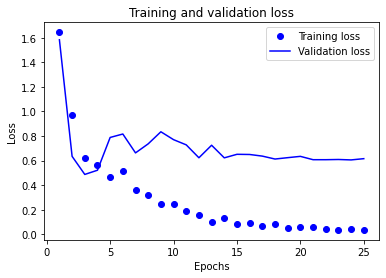

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)

plt.clf()
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

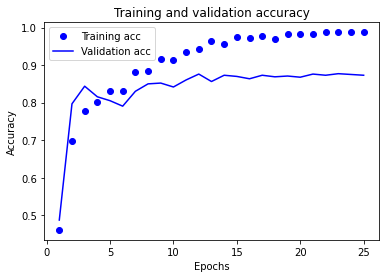

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# predict and get accuracy score

y_cnn_pred_class = model.predict(test_dataset)

In [ ]:
y_cnn_pred = le.inverse_transform(np.argmax(y_cnn_pred_class, axis=-1))

In [ ]:
le = LabelEncoder()
y_cnn_pred = le.fit_transform(y_cnn_pred)
y_cnn_pred[:100]

array([2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1,
       2, 2, 0, 2, 2, 5, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 1, 2, 2, 1,
       1, 1, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
y_true = test_labels[:num_test_samples]
y_true[:100]

array([2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       1, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_cnn_pred)

0.899

## 2.7. Wrongly Predicted Images

In [ ]:
# choose benchmark y

my_y_true = y_true

# choose predicted y

my_y_pred = y_cnn_pred # cnn w/ img augmentation

In [ ]:
pd_y_pred=pd.Series(my_y_pred, name="predictions")
pd_y_pred

0       2
1       1
2       1
3       2
4       2
       ..
3995    2
3996    2
3997    2
3998    2
3999    2
Name: predictions, Length: 4000, dtype: int64

In [ ]:
pd_y_true=pd.Series(my_y_true, name="true class")
pd_y_true

0       2
1       1
2       1
3       2
4       2
       ..
3995    2
3996    2
3997    2
3998    2
3999    2
Name: true class, Length: 4000, dtype: int64

In [ ]:
dict={1:'urban', 2:'agriculture', 3:'flora', 5:'wetland',6:'barren',7:'water'}
pd_y_pred.replace(dict,inplace=True)
pd_y_pred

0             flora
1             flora
2             flora
3       agriculture
4             flora
           ...     
1995          flora
1996    agriculture
1997          flora
1998          flora
1999          urban
Name: predictions, Length: 2000, dtype: object

In [ ]:
pd_y_true.replace(dict,inplace=True)
pd_y_true

NameError: ignored

In [ ]:
# find wrong predictions

X_wrong_idx=pd_y_pred[pd_y_pred!=pd_y_true].index.values
len(X_wrong_idx)

489

In [ ]:
test_input_imgs = input_imgs[num_train_samples + num_val_samples:num_total_samples]


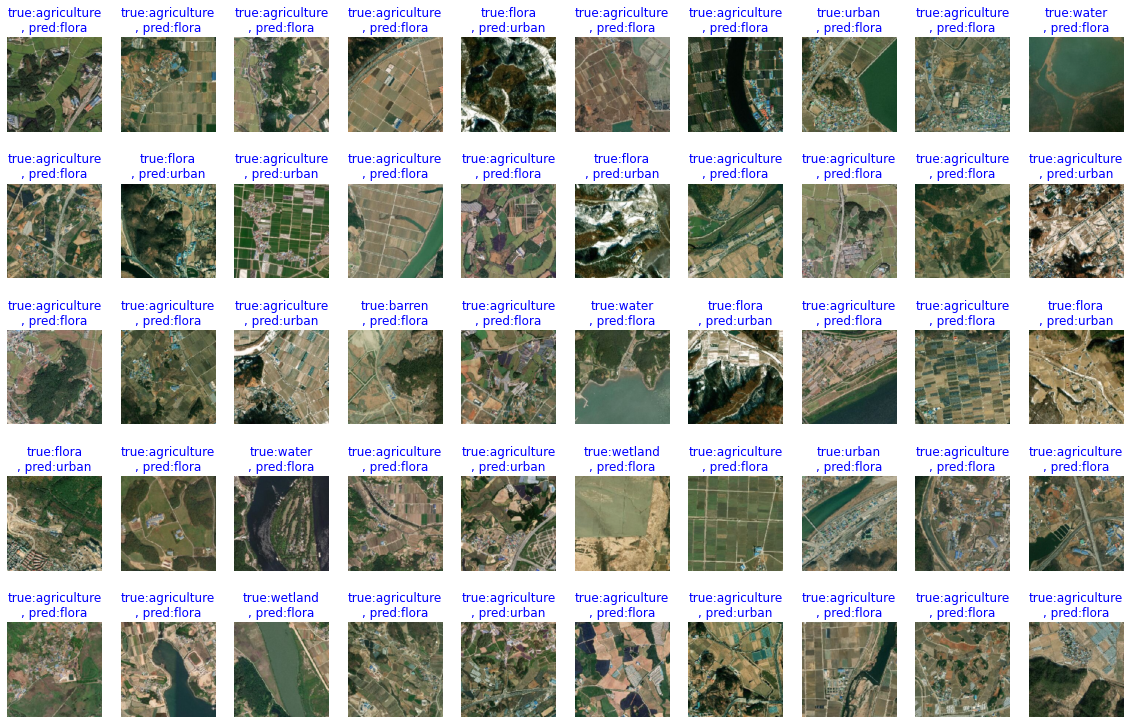

In [ ]:
# Plot Wrongly Predicted Images
from keras.preprocessing import image

plt.figure(figsize=(20,13))

num_subplots=50

# randomnize order
import random
random.shuffle(X_wrong_idx)

for i in range(num_subplots):
  j=X_wrong_idx[i]
  plt.subplot(5,10,i+1)
  plt.imshow(image.array_to_img(test_input_imgs[j]),cmap='binary', interpolation='bilinear')
  plt.axis('off')
  plt.title('true:{}\n, pred:{}'.format(pd_y_true[j], pd_y_pred[j]), fontsize=12, color='blue')

plt.show()


## 2.8. Confusion Matrix

In [ ]:
# confusion matrics

from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(my_y_true, my_y_pred)

In [ ]:
conf_mx

array([[ 112,    2,    0,    1,    4,    1],
       [  28,  558,   27,   10,    9,    5],
       [  56,  176, 2869,   13,   14,   45],
       [   0,    0,    0,    5,    0,    1],
       [   1,    0,    0,    1,    4,    0],
       [   2,    1,    1,    5,    1,   48]])

In [ ]:
# confusion matrix plot

import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    plt.figure(figsize=(12, 9))

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.3f}; misclass={:0.3f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
my_classes=np.array(['urban', 'agriculture', 'flora', 'wetland', 'barren', 'water'])
my_classes

array(['urban', 'agriculture', 'flora', 'wetland', 'barren', 'water'],
      dtype='<U11')

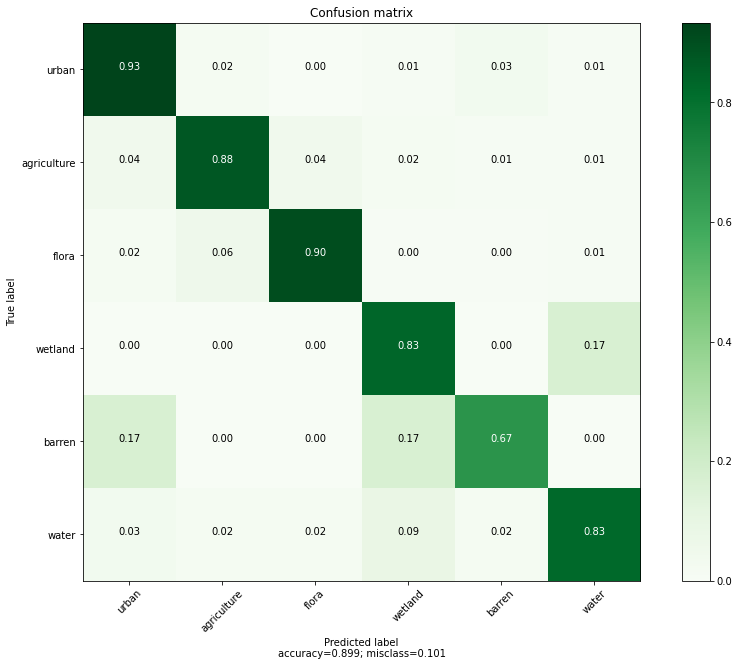

In [ ]:
# plot confusion matrix (raw)

plot_confusion_matrix(conf_mx, my_classes, cmap='Greens', normalize=True)

In [ ]:
# save model
model.save('best_model.h5')

In [ ]:
# download saved model
from google.colab import files
files.download('best_model.h5') 

# Reload the model

In [ ]:
#reload_model = tf.keras.models.load_model('best_model.h5')

#predictions = reload_model.predict(some_flowers, batch_size=16)
#evaluations = reload_model.evaluate(some_flowers, some_labels, batch_size=16)
#print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
#print('[val_loss, val_acc]', evaluations)
#display_9_images_with_predictions(some_flowers, predictions, some_labels)